### Goal

This notebook aims at analysing the impact of smoke generated from wildfires within 650 mile radius from Madison, WI on the health of the community. The main focus is in analysing the relationship between previously calculated smoke estimates and the respiratory health (illness and mortality of Astham, COPD and TB) in Madison. Additionally we will use the forecasted smoke estimates to predict the prevelance of the mentioned diseases for next 25 years so that Madison city council can stay prepared.

### Licence

The code in the notebook is licensed under standard [MIT licence](https://github.com/ManasaSRonur/data-512-project/blob/main/LICENSE).

In [29]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tools.eval_measures import rmse
import itertools
import warnings
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import dcor



In [30]:
smoke_df = pd.read_csv('intermediary_files/madison_yearly_smoke_estimate_1964_2024.csv')
forecasted_smoke_df = pd.read_csv('intermediary_files/forecasted_smoke_estimates.csv')

In [31]:
health_df = pd.read_csv('intermediary_files/respiratory_illness_mortality_data.csv')

In [32]:
# Merge dataframes on the common column 'Year'
merged_df = pd.merge(health_df, smoke_df, left_on='Year', right_on='Fire_Year', how='inner').drop(columns=['Fire_Year'])

print(merged_df.columns)


Index(['Year', 'Illness_crude_rate_asthma', 'Illness_crude_rate_copd',
       'Cases_tb', 'Death_percent_asthma', 'Death_percent_copd',
       'Death_percent_tb', 'Smoke_Estimate'],
      dtype='object')


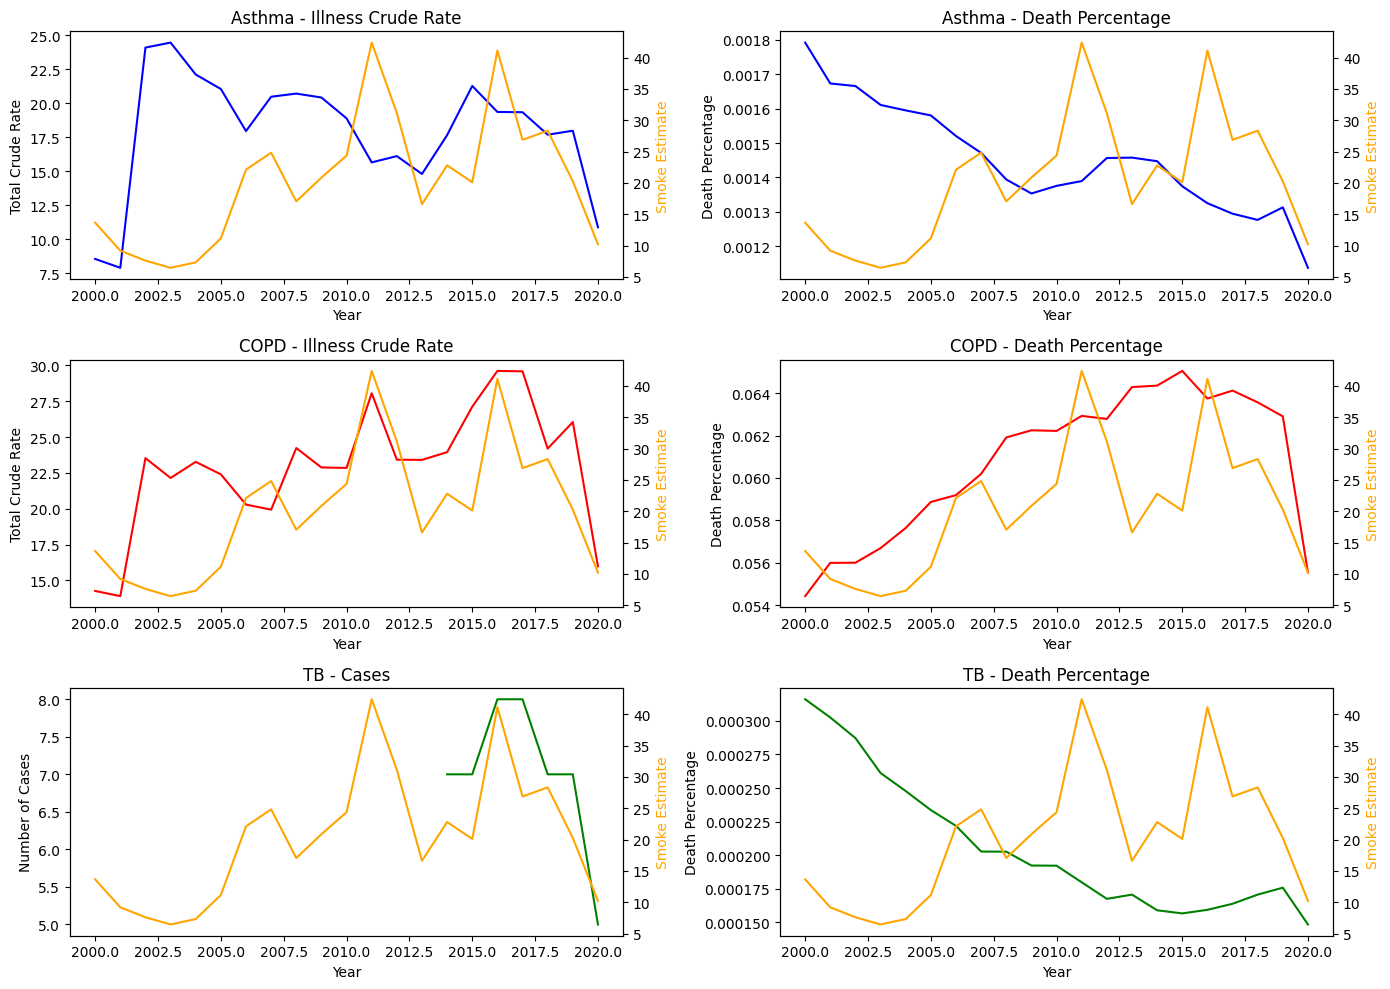

In [33]:

# Filter data for years from 2000 onward
filtered_df = merged_df[(merged_df['Year'] >= 2000) & (merged_df['Year'] <= 2023)]
filtered_df.loc[:, 'Year'] = filtered_df['Year'].astype(int)


import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 10))

# Asthma Plots
axs[0, 0].plot(filtered_df['Year'], filtered_df['Illness_crude_rate_asthma'], color='blue')
axs[0, 0].set_title('Asthma - Illness Crude Rate')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Total Crude Rate')

# Add secondary axis for Smoke_estimate
ax2_0 = axs[0, 0].twinx()
ax2_0.plot(filtered_df['Year'], filtered_df['Smoke_Estimate'], color='orange')
ax2_0.set_ylabel('Smoke Estimate', color='orange')

axs[0, 1].plot(filtered_df['Year'], filtered_df['Death_percent_asthma'],  color='blue')
axs[0, 1].set_title('Asthma - Death Percentage')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Death Percentage')

# Add secondary axis for Smoke_estimate
ax2_1 = axs[0, 1].twinx()
ax2_1.plot(filtered_df['Year'], filtered_df['Smoke_Estimate'],  color='orange')
ax2_1.set_ylabel('Smoke Estimate', color='orange')

# COPD Plots
axs[1, 0].plot(filtered_df['Year'], filtered_df['Illness_crude_rate_copd'],  color='red')
axs[1, 0].set_title('COPD - Illness Crude Rate')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Total Crude Rate')

# Add secondary axis for Smoke_estimate
ax2_2 = axs[1, 0].twinx()
ax2_2.plot(filtered_df['Year'], filtered_df['Smoke_Estimate'], color='orange')
ax2_2.set_ylabel('Smoke Estimate', color='orange')

axs[1, 1].plot(filtered_df['Year'], filtered_df['Death_percent_copd'],  color='red')
axs[1, 1].set_title('COPD - Death Percentage')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Death Percentage')

# Add secondary axis for Smoke_estimate
ax2_3 = axs[1, 1].twinx()
ax2_3.plot(filtered_df['Year'], filtered_df['Smoke_Estimate'],  color='orange')
ax2_3.set_ylabel('Smoke Estimate', color='orange')

# TB Plots
axs[2, 0].plot(filtered_df['Year'], filtered_df['Cases_tb'], color='green')
axs[2, 0].set_title('TB - Cases')
axs[2, 0].set_xlabel('Year')
axs[2, 0].set_ylabel('Number of Cases')

# Add secondary axis for Smoke_estimate
ax2_4 = axs[2, 0].twinx()
ax2_4.plot(filtered_df['Year'], filtered_df['Smoke_Estimate'],  color='orange')
ax2_4.set_ylabel('Smoke Estimate', color='orange')

axs[2, 1].plot(filtered_df['Year'], filtered_df['Death_percent_tb'],  color='green')
axs[2, 1].set_title('TB - Death Percentage')
axs[2, 1].set_xlabel('Year')
axs[2, 1].set_ylabel('Death Percentage')

# Add secondary axis for Smoke_estimate
ax2_5 = axs[2, 1].twinx()
ax2_5.plot(filtered_df['Year'], filtered_df['Smoke_Estimate'],  color='orange')
ax2_5.set_ylabel('Smoke Estimate', color='orange')

# Adjust layout and display
plt.tight_layout()
plt.show()


In [34]:
# Analyze correlation between smoke intake and hospitalization rates/incidence
correlation_matrix = merged_df.drop(columns=['Year']).dropna().corr()

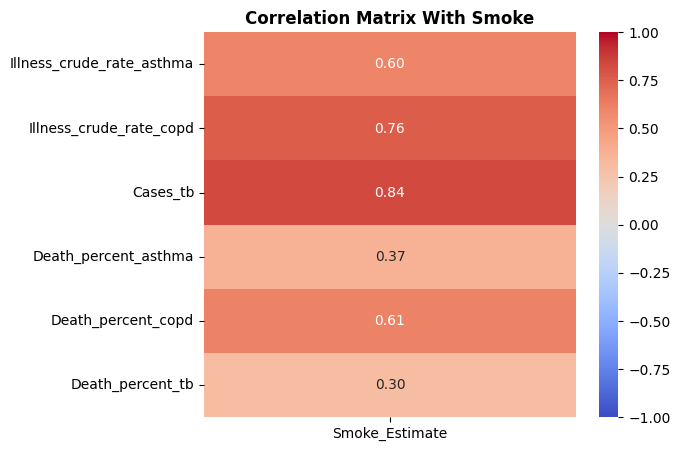

In [35]:
# Plot a heatmap
plt.figure(figsize=(6, 5))
h = sns.heatmap(correlation_matrix[['Smoke_Estimate']].iloc[:-1,:], annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
# Tilt x-axis labels
_ = h.set_xticklabels(h.get_xticklabels(), rotation=0, ha='center')
plt.title('Correlation Matrix With Smoke', weight= 'bold')
plt.show()

In [36]:
# df = merged_df.drop(columns=['Year']).dropna()

# # Create a dataframe to store p-values
# p_values = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)

# # Compute the p-values for each pair of variables
# for i in df.columns:
#     for j in df.columns:
#         if i != j:
#             dist_corr = dcor.distance_correlation(df[i], df[j])
#             p_values.loc[i, j] = dist_corr
#         else:
#             p_values.loc[i, j] = np.nan

# print("P-values Matrix:")
# print(p_values)

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(p_values, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)

# # Add labels and title
# plt.title("P-values Heatmap", fontsize=16)
# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)
# plt.tight_layout()

# # Show the plot
# plt.show()

In [37]:
smoke_df = pd.concat([smoke_df[['Fire_Year', 'Smoke_Estimate']], forecasted_smoke_df], axis=0)
merged_df = smoke_df.merge(health_df, left_on='Fire_Year', right_on='Year', how='left').drop(columns=['Year']).rename(columns = {'Fire_Year': "Year"})
merged_df = merged_df[merged_df['Year'] >= 2000]
merged_df.head()

,Year,Smoke_Estimate,Illness_crude_rate_asthma,Illness_crude_rate_copd,Cases_tb,Death_percent_asthma,Death_percent_copd,Death_percent_tb
36,2000,13.650358,8.540000,14.260000,NaN,0.001792,0.054428,0.000316
37,2001,9.186901,7.890000,13.900000,NaN,0.001673,0.055997,0.000302
38,2002,7.602821,24.087182,23.530327,NaN,0.001665,0.056004,0.000287
39,2003,6.454358,24.453773,22.147407,NaN,0.001611,0.056693,0.000261
40,2004,7.318638,22.105566,23.271017,NaN,0.001595,0.057643,0.000248


In [38]:
endog_col_dict = {
    "Asthma": [
        'Death_percent_asthma',
        'Illness_crude_rate_asthma'
    ],
    "COPD": [
        'Death_percent_copd',
        'Illness_crude_rate_copd'
    ],
    "TB": [
        'Cases_tb',
        'Death_percent_tb'
    ]
}

exog_cols = [
    'Smoke_Estimate'
]

In [39]:
p_q_dict= {
    "Asthma": (2,2),
    "COPD": (2,2),
    "TB": (1,1),
}

In [40]:
def build_and_evaluate(var_name):
    """
    Calculate and display performance metrics for the time series model.
    
    Args:
        var_name (str): Name of the variable being forecasted
    """
    endog_cols = endog_col_dict[var_name]
    
    # Select training data (2000-2022)
    train_data = merged_df[merged_df['Year'].isin(range(2000, 2022))]
    
    # Standardize the data
    scaler_endog = StandardScaler()
    scaler_exog = StandardScaler()
    
    # Fit the scalers and transform the data
    train_endog_scaled = scaler_endog.fit_transform(train_data[endog_cols])
    train_exog_scaled = scaler_exog.fit_transform(train_data[exog_cols])
    
    # Fit the model
    order = (2, 2)  # Current model order
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            # Fit VARMAX model
            model = VARMAX(train_endog_scaled, exog=train_exog_scaled, order=order)
            results = model.fit(disp=False)
            
            # Get fitted values
            fitted_values = scaler_endog.inverse_transform(results.fittedvalues)
            actual_values = train_data[endog_cols].values
            
            # Calculate metrics
            mae = np.mean(np.abs(fitted_values - actual_values))
            rmse = np.sqrt(np.mean((fitted_values - actual_values)**2))
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            # Calculate R-squared
            ss_res = np.sum((actual_values - fitted_values) ** 2)
            ss_tot = np.sum((actual_values - np.mean(actual_values)) ** 2)
            r2 = 1 - (ss_res / ss_tot)
            
            # Get model information criteria
            aic = results.aic
            bic = results.bic
            
            # Create metrics dictionary
            metrics = {
                'MAE': mae,
                'RMSE': rmse,
                'MAPE': mape,
                'R-squared': r2,
                'AIC': aic,
                'BIC': bic
            }
            
            # Print metrics
            print(f"\nModel Performance Metrics for {var_name}:")
            print("-" * 50)
            print(f"Mean Absolute Error (MAE): {mae:.2f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            print(f"R-squared: {r2:.3f}")
            print(f"Akaike Information Criterion (AIC): {aic:.2f}")
            print(f"Bayesian Information Criterion (BIC): {bic:.2f}")
            
            # Plot actual vs fitted values
            plt.figure(figsize=(8, 6))
            for i, col in enumerate(endog_cols):
                plt.subplot(len(endog_cols), 1, i+1)
                plt.plot(train_data['Year'], actual_values[:, i], label='Actual')
                plt.plot(train_data['Year'], fitted_values[:, i], 'r--', label='Fitted')
                plt.title(f'{col} - Actual vs Fitted Values')
                plt.xlabel('Year')
                plt.ylabel('Value')
                plt.legend()
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error calculating metrics for {var_name}: {e}")
            return None



Model Performance Metrics for Asthma:
--------------------------------------------------
Mean Absolute Error (MAE): 0.62
Root Mean Square Error (RMSE): 1.32
Mean Absolute Percentage Error (MAPE): 7.23%
R-squared: 0.980
Akaike Information Criterion (AIC): 76.69
Bayesian Information Criterion (BIC): 101.78


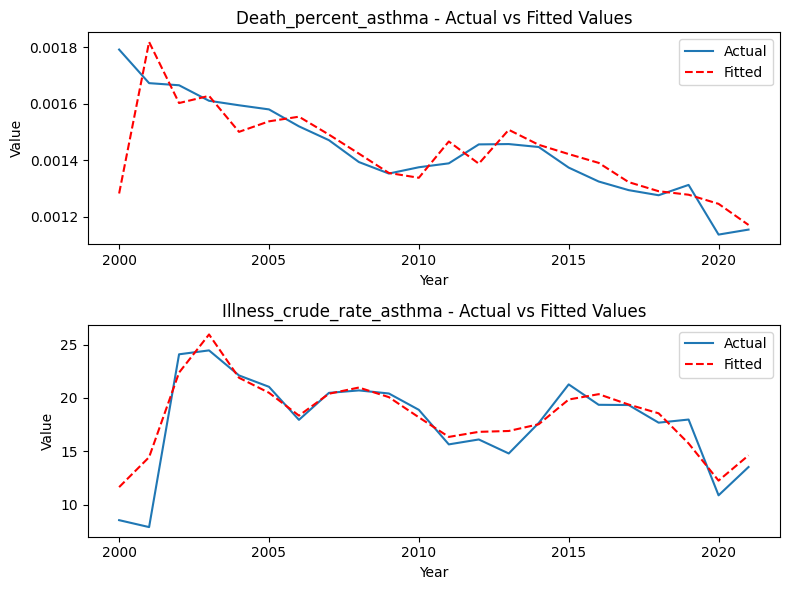

In [41]:
build_and_evaluate('Asthma')


Model Performance Metrics for COPD:
--------------------------------------------------
Mean Absolute Error (MAE): 0.97
Root Mean Square Error (RMSE): 1.76
Mean Absolute Percentage Error (MAPE): 5.64%
R-squared: 0.977
Akaike Information Criterion (AIC): 97.58
Bayesian Information Criterion (BIC): 122.68


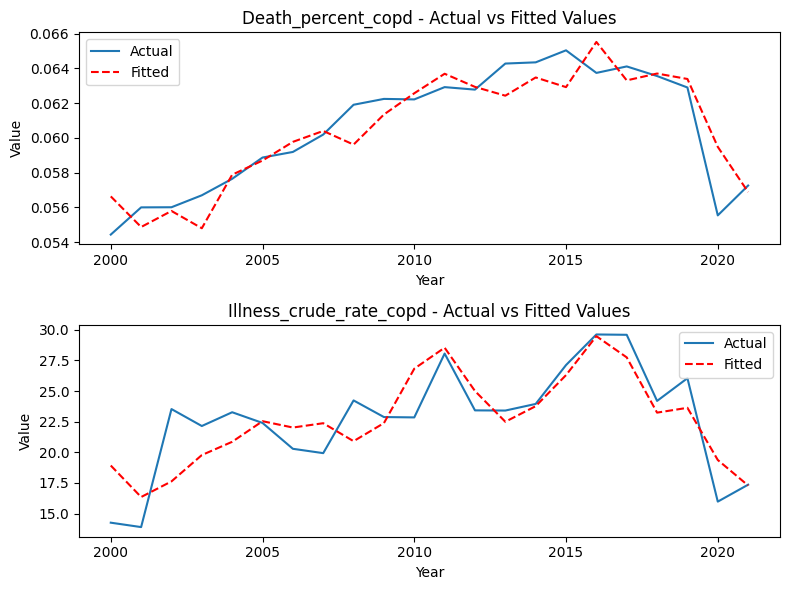

In [42]:
build_and_evaluate('COPD')


Model Performance Metrics for TB:
--------------------------------------------------
Mean Absolute Error (MAE): nan
Root Mean Square Error (RMSE): nan
Mean Absolute Percentage Error (MAPE): nan%
R-squared: nan
Akaike Information Criterion (AIC): 35.53
Bayesian Information Criterion (BIC): 60.62


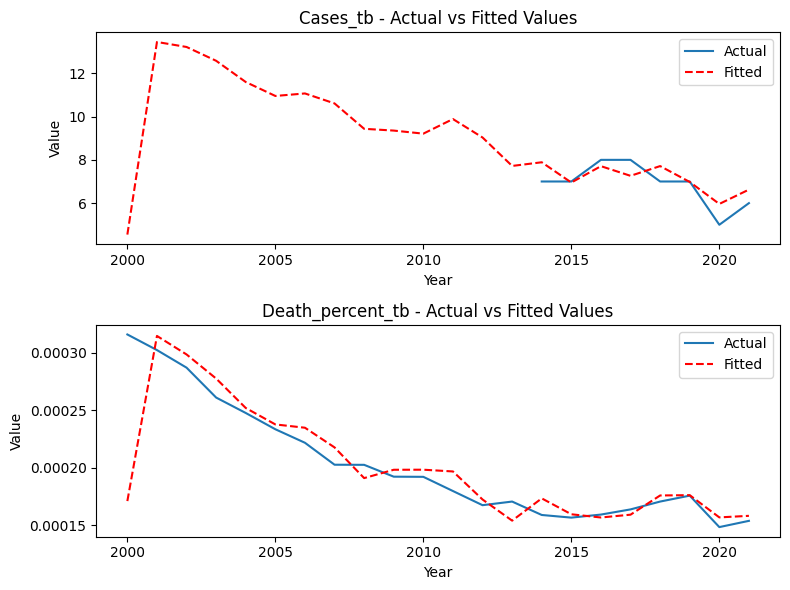

In [43]:
build_and_evaluate('TB')

In [44]:
def health_forecast(var_name):
    """
    Generate time series forecasts with confidence intervals using VARMAX model.
    
    Args:
        var_name (str): Name of the variable to forecast
        
    Returns:
        pd.DataFrame: Forecast results including mean predictions and confidence intervals
    """
    endog_cols = endog_col_dict[var_name]
    
    # Select data for training (2000–2019) and forecast (2020–2050)
    full_data = merged_df[merged_df['Year'].isin(range(2000, 2022))]
    new_data = merged_df[merged_df['Year'].isin(range(2023, 2051))]
    
    #  Order of the VAR process
    order = (2,2)  
    
    # Standardize the data
    scaler_endog = StandardScaler()
    scaler_exog = StandardScaler()
    
    # Fit the scaler only on columns that are in full_data and new_data
    full_data_endog_scaled = scaler_endog.fit_transform(full_data[endog_cols])
    full_data_exog_scaled = scaler_exog.fit_transform(full_data[exog_cols])
    new_data_exog_scaled = scaler_exog.transform(new_data[exog_cols])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            # Fit the VARMAX model on the scaled training data
            model = VARMAX(full_data_endog_scaled, exog=full_data_exog_scaled, order=order)    
            results = model.fit(disp=False)

            # Forecast future values on the scaled data with confidence intervals
            forecast_steps = len(new_data)
            forecast = results.get_forecast(steps=forecast_steps, exog=new_data_exog_scaled)

            # Extract forecasted means and confidence intervals
            forecast_mean = forecast.predicted_mean
            forecast_ci = forecast.conf_int(alpha=0.05)  # 95% confidence interval

            # Convert forecast mean to DataFrame
            forecast_df = pd.DataFrame(scaler_endog.inverse_transform(forecast_mean), 
                                     columns=endog_cols, 
                                     index=range(2023, 2023 + forecast_steps))
            
            # Transform confidence intervals back to original scale
            # Split CI array into lower and upper bounds
            ci_lower = scaler_endog.inverse_transform(forecast_ci[:, :len(endog_cols)])
            ci_upper = scaler_endog.inverse_transform(forecast_ci[:, len(endog_cols):])
            
            # Create DataFrames for lower and upper bounds
            ci_lower_df = pd.DataFrame(
                ci_lower,
                columns=[f"{col}_lower" for col in endog_cols],
                index=range(2023, 2023 + forecast_steps)
            )
            ci_upper_df = pd.DataFrame(
                ci_upper,
                columns=[f"{col}_upper" for col in endog_cols],
                index=range(2023, 2023 + forecast_steps)
            )

            # Combine forecasts and confidence intervals
            forecast_df = pd.concat([forecast_df, ci_lower_df, ci_upper_df], axis=1)

            # Ensure no forecasted values or CI bounds are below zero
            forecast_df = forecast_df.clip(lower=0)

        except np.linalg.LinAlgError as e:
            print(f"Covariance issue with VARMAX model for {var_name}: {e}")
            return None
        except Exception as e:
            print(f"Error in forecasting for {var_name}: {e}")
            return None
    
    # Add smoke data
    smoke_data = new_data[['Year', 'Smoke_Estimate']].set_index('Year')
    forecast_df = forecast_df.join(smoke_data)
    
    return forecast_df

In [45]:
asthma_df = health_forecast('Asthma')
asthma_df.head()

,Death_percent_asthma,Illness_crude_rate_asthma,Death_percent_asthma_lower,Illness_crude_rate_asthma_lower,Death_percent_asthma_upper,Illness_crude_rate_asthma_upper,Smoke_Estimate
2023,0.001267,14.850782,0.001134,12.469444,0.001401,17.232121,33.207422
2024,0.001346,12.323866,0.001107,8.635649,0.001585,16.012082,34.447835
2025,0.001435,13.345908,0.001132,9.122265,0.001738,17.569552,35.711001
2026,0.001535,15.386585,0.001177,9.726452,0.001894,21.046718,36.996922
2027,0.001625,17.923733,0.001223,10.395913,0.002026,25.451554,38.305597


In [46]:
copd_df = health_forecast('COPD')
copd_df.head()

,Death_percent_copd,Illness_crude_rate_copd,Death_percent_copd_lower,Illness_crude_rate_copd_lower,Death_percent_copd_upper,Illness_crude_rate_copd_upper,Smoke_Estimate
2023,0.057490,13.819278,0.054716,10.106804,0.060265,17.531751,33.207422
2024,0.059249,19.062377,0.055475,14.363548,0.063023,23.761206,34.447835
2025,0.058658,20.448638,0.054175,12.833591,0.063141,28.063686,35.711001
2026,0.059845,22.164674,0.055094,13.905538,0.064596,30.423811,36.996922
2027,0.061317,23.367689,0.055989,14.763024,0.066645,31.972353,38.305597


In [47]:
tb_df = health_forecast('TB')
tb_df.head()

,Cases_tb,Death_percent_tb,Cases_tb_lower,Death_percent_tb_lower,Cases_tb_upper,Death_percent_tb_upper,Smoke_Estimate
2023,6.039682,0.000132,4.925071,0.000123,7.154292,0.000142,33.207422
2024,6.411629,0.000130,5.183204,0.000113,7.640054,0.000147,34.447835
2025,6.356478,0.000133,4.814767,0.000094,7.898188,0.000172,35.711001
2026,6.489421,0.000137,4.680452,0.000086,8.298391,0.000187,36.996922
2027,6.681983,0.000141,4.384252,0.000080,8.979713,0.000202,38.305597


In [48]:
# Create the future_df by concatenating all disease forecasts
future_df = pd.DataFrame(index=range(2023, 2051))

# Add each disease's forecasts
for df in [asthma_df, copd_df, tb_df]:
    if df is not None:
        for col in df.columns:
            future_df[col] = df[col]

# Add Smoke_Estimate
smoke_data = merged_df[merged_df['Year'].isin(range(2023, 2051))]['Smoke_Estimate'].values
future_df['Smoke_Estimate'] = smoke_data

# Reset index and rename
future_df = future_df.reset_index().rename(columns={'index': 'Year'})
future_df.head()

,Year,Death_percent_asthma,Illness_crude_rate_asthma,Death_percent_asthma_lower,Illness_crude_rate_asthma_lower,Death_percent_asthma_upper,Illness_crude_rate_asthma_upper,Smoke_Estimate,Death_percent_copd,Illness_crude_rate_copd,Death_percent_copd_lower,Illness_crude_rate_copd_lower,Death_percent_copd_upper,Illness_crude_rate_copd_upper,Cases_tb,Death_percent_tb,Cases_tb_lower,Death_percent_tb_lower,Cases_tb_upper,Death_percent_tb_upper
0,2023,0.001267,14.850782,0.001134,12.469444,0.001401,17.232121,33.207422,0.057490,13.819278,0.054716,10.106804,0.060265,17.531751,6.039682,0.000132,4.925071,0.000123,7.154292,0.000142
1,2024,0.001346,12.323866,0.001107,8.635649,0.001585,16.012082,34.447835,0.059249,19.062377,0.055475,14.363548,0.063023,23.761206,6.411629,0.000130,5.183204,0.000113,7.640054,0.000147
2,2025,0.001435,13.345908,0.001132,9.122265,0.001738,17.569552,35.711001,0.058658,20.448638,0.054175,12.833591,0.063141,28.063686,6.356478,0.000133,4.814767,0.000094,7.898188,0.000172
3,2026,0.001535,15.386585,0.001177,9.726452,0.001894,21.046718,36.996922,0.059845,22.164674,0.055094,13.905538,0.064596,30.423811,6.489421,0.000137,4.680452,0.000086,8.298391,0.000187
4,2027,0.001625,17.923733,0.001223,10.395913,0.002026,25.451554,38.305597,0.061317,23.367689,0.055989,14.763024,0.066645,31.972353,6.681983,0.000141,4.384252,0.000080,8.979713,0.000202


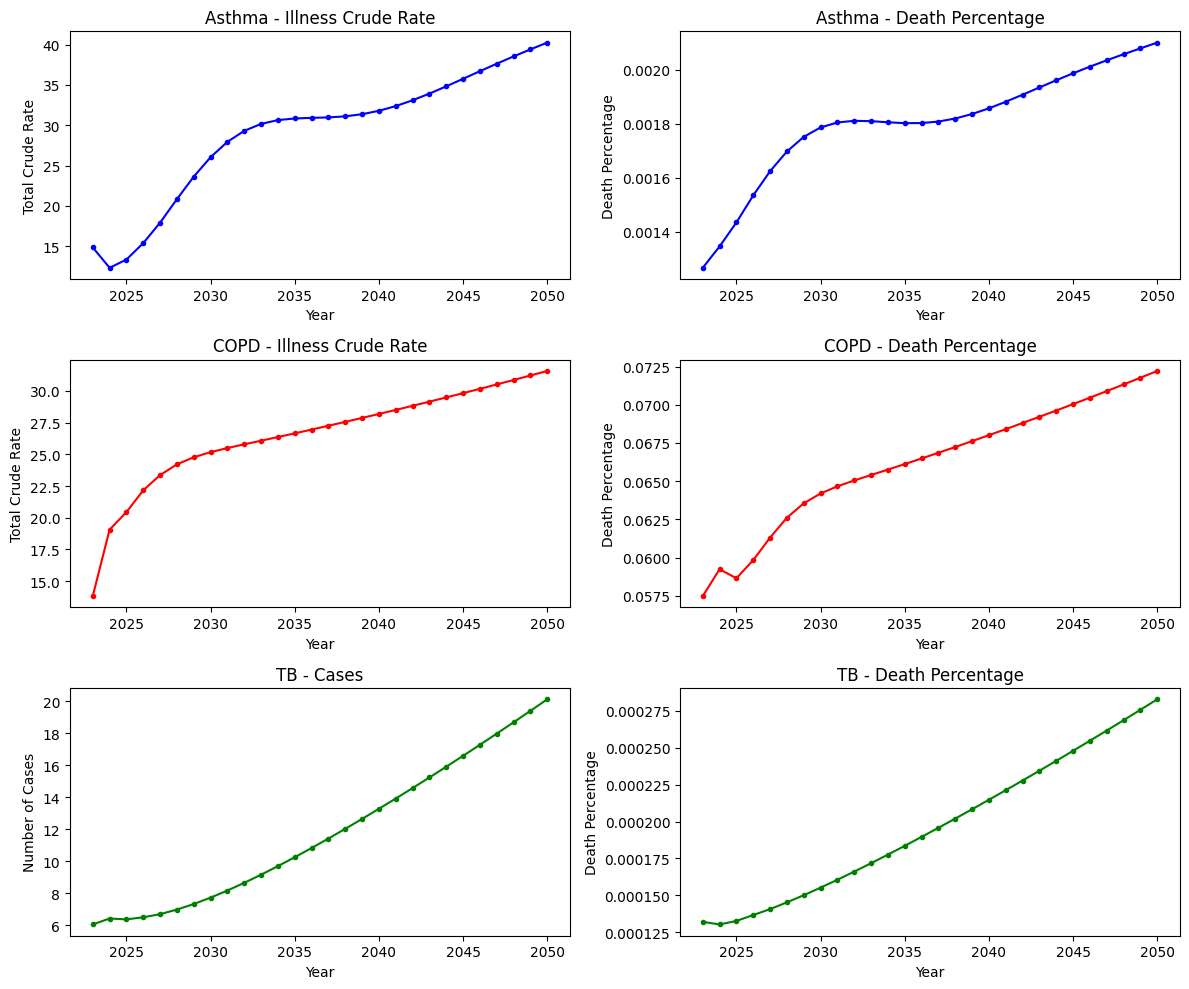

In [49]:
# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Asthma Plots
axs[0, 0].plot(future_df['Year'], future_df['Illness_crude_rate_asthma'], marker='.', color='blue')
axs[0, 0].set_title('Asthma - Illness Crude Rate')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Total Crude Rate')

axs[0, 1].plot(future_df['Year'], future_df['Death_percent_asthma'], marker='.', color='blue')
axs[0, 1].set_title('Asthma - Death Percentage')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Death Percentage')

# COPD Plots
axs[1, 0].plot(future_df['Year'], future_df['Illness_crude_rate_copd'], marker='.', color='red')
axs[1, 0].set_title('COPD - Illness Crude Rate')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Total Crude Rate')

axs[1, 1].plot(future_df['Year'], future_df['Death_percent_copd'], marker='.', color='red')
axs[1, 1].set_title('COPD - Death Percentage')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Death Percentage')

# TB Plots
axs[2, 0].plot(future_df['Year'], future_df['Cases_tb'], marker='.', color='green')
axs[2, 0].set_title('TB - Cases')
axs[2, 0].set_xlabel('Year')
axs[2, 0].set_ylabel('Number of Cases')

axs[2, 1].plot(future_df['Year'], future_df['Death_percent_tb'], marker='.', color='green')
axs[2, 1].set_title('TB - Death Percentage')
axs[2, 1].set_xlabel('Year')
axs[2, 1].set_ylabel('Death Percentage')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [50]:

# # Create a figure with subplots
# fig, axs = plt.subplots(3, 2, figsize=(12, 10))
# fig.suptitle('Health Metrics by Illness Over Time with 95% Confidence Intervals', fontsize=16)

# # Asthma Plots
# axs[0, 0].plot(future_df['Year'], future_df['Total_crude_rate_asthma'], marker='.', color='blue', label='Forecast')
# axs[0, 0].fill_between(future_df['Year'], 
#                        future_df['Total_crude_rate_asthma_lower'],
#                        future_df['Total_crude_rate_asthma_upper'],
#                        alpha=0.1, color='blue', label='95% CI')
# axs[0, 0].set_title('Asthma - Total Crude Rate')
# axs[0, 0].set_xlabel('Year')
# axs[0, 0].set_ylabel('Total Crude Rate')
# axs[0, 0].legend()

# axs[0, 1].plot(future_df['Year'], future_df['Death_percent_asthma'], marker='.', color='blue', label='Forecast')
# axs[0, 1].fill_between(future_df['Year'],
#                        future_df['Death_percent_asthma_lower'],
#                        future_df['Death_percent_asthma_upper'],
#                        alpha=0.1, color='blue', label='95% CI')
# axs[0, 1].set_title('Asthma - Death Percentage')
# axs[0, 1].set_xlabel('Year')
# axs[0, 1].set_ylabel('Death Percentage')
# axs[0, 1].legend()

# # COPD Plots
# axs[1, 0].plot(future_df['Year'], future_df['Total_crude_rate_copd'], marker='.', color='red', label='Forecast')
# axs[1, 0].fill_between(future_df['Year'],
#                        future_df['Total_crude_rate_copd_lower'],
#                        future_df['Total_crude_rate_copd_upper'],
#                        alpha=0.1, color='red', label='95% CI')
# axs[1, 0].set_title('COPD - Total Crude Rate')
# axs[1, 0].set_xlabel('Year')
# axs[1, 0].set_ylabel('Total Crude Rate')
# axs[1, 0].legend()

# axs[1, 1].plot(future_df['Year'], future_df['Death_percent_copd'], marker='.', color='red', label='Forecast')
# axs[1, 1].fill_between(future_df['Year'],
#                        future_df['Death_percent_copd_lower'],
#                        future_df['Death_percent_copd_upper'],
#                        alpha=0.1, color='red', label='95% CI')
# axs[1, 1].set_title('COPD - Death Percentage')
# axs[1, 1].set_xlabel('Year')
# axs[1, 1].set_ylabel('Death Percentage')
# axs[1, 1].legend()

# # TB Plots
# axs[2, 0].plot(future_df['Year'], future_df['Cases_tb'], marker='.', color='green', label='Forecast')
# axs[2, 0].fill_between(future_df['Year'],
#                        future_df['Cases_tb_lower'],
#                        future_df['Cases_tb_upper'],
#                        alpha=0.1, color='green', label='95% CI')
# axs[2, 0].set_title('TB - Cases')
# axs[2, 0].set_xlabel('Year')
# axs[2, 0].set_ylabel('Number of Cases')
# axs[2, 0].legend()

# axs[2, 1].plot(future_df['Year'], future_df['Death_percent_tb'], marker='.', color='green', label='Forecast')
# axs[2, 1].fill_between(future_df['Year'],
#                        future_df['Death_percent_tb_lower'],
#                        future_df['Death_percent_tb_upper'],
#                        alpha=0.1, color='green', label='95% CI')
# axs[2, 1].set_title('TB - Death Percentage')
# axs[2, 1].set_xlabel('Year')
# axs[2, 1].set_ylabel('Death Percentage')
# axs[2, 1].legend()

# # Adjust layout and display
# plt.tight_layout()
# plt.show()